# EEG Data, Implementation, and Results
The purpose of this document is to provide a centralized live view of the EEG data as well as our implementation and results. This document will contain both information about the previous literature as well as code that helps us analyze the data and the predictive models operating on the data. While this is nice for quickly prototyping and explaining methodologies, there is a script in this repository called `eeg_ann.py` (run `python eeg_ann.py --help` for a list of flags) which is more suited for design space explorations / large scale experiments. I will first briefly go over IBM's published work in this area to determine their thought process through this problem. Then, I will go over visualization of the data in the dataset that we have. Then, I will apply neural network models to the data and determine their effectiveness. Lastly, I will leave a portion for future work to contain more novel experiments.

### 1.0 Paper Overview

#### 1.1 A Generalizable Brain-Computer Interface (BCI) Using Machine Learning for Feature Discovery (June 26, 2015)

This is the first work that published the data set that we are using, but doesn't utilize TrueNorth at all. They use a genetic algorithm to create multi-layer perceptrons with hyperbolic tangeant activations. All of this is implemented in MATLAB. They get an 86% accuracy on Particpant D using their approach.

#### 1.2 Decoding EEG and LFP Signals using Deep Learning: Heading TrueNorth (May 16, 2016)

In this work, all experiments were conducted on participant D of Nurse et al. "A Generalizable Brain-Computer Interface (BCI) Using Machine Learning for Feature Discovery". The dataset was split up into 964 training set samples and 145 testing samples. They used the following convolutional neural network archietcture: 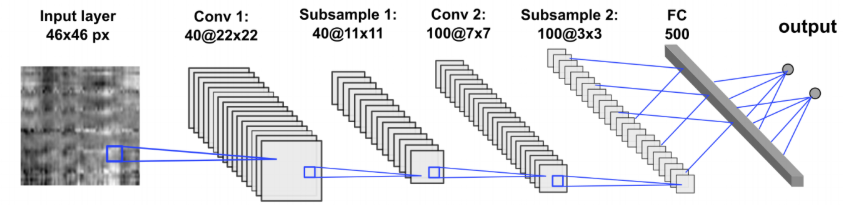 and trained it using Caffe. The authors state that they use the original tea learning approach presented by Esser et al. "Backpropagation for energy-efficient neuromorphic computing" (interestingly the first case of mapping a convolutional network using tea learning that I have seen). The unconstrained network achieves a 81% while the constrained deployed network achieves a 76%. They claim that the lower accuracy is because they didn't fully explore the design space of the neural networks.

#### 1.3 Neural-Network-Based Analysis of EEG Data Using the Neuromorphic TrueNorth Chip for Brain-Machine Interfaces (May 8, 2017)

This work uses the same methodology as Yepes et al. "Improving Classification Accuracy of Feedforward Neural Networks for Spiking Neuromorphic Chips", but on a new data set. They utlized the BCI Competition III dataset IIIb. This dataset can be found at the following link: http://www.bbci.de/competition/iii/#data_set_iiib. We should look at this dataset to see if it is better to use than the one provided by Nurse et al. "A Generalizable Brain-Computer Interface Using Machine Learning for Feature Discovery"

#### 1.4  Improving Classification Accuracy of Feedforward Neural Networks for Spiking Neuromorphic Chips (May 19, 2017)

This paper introduces a new type of probabalistic training and runs experiments on MNIST as well as the EEG data collected from participant D. This is the same type of training that we currently use, so we should get similar results. We have already verified that we outperform their MNIST results in which we credit the ADAM optimizer and other optimizations in TensorFlow. For the EEG data They use a training set of 948 and a testing set of 161. They use the "large network" defined by the following table (note after the first layer stride refers to outputs from entire cores): 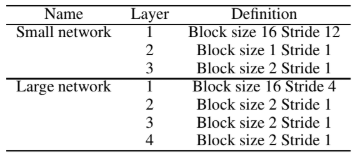 They report the following accuracies with varying the number of ticks they use to encode the data: 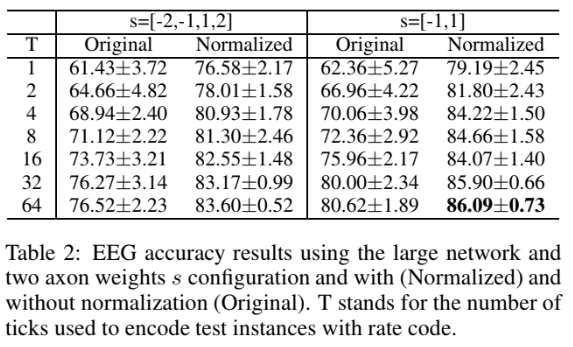 In this figure, they refer to both original and normalized data. The normalization they use is with the following equation: 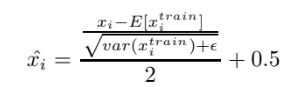 They are not clear how this formula ensures that the input data will be between 0 and 1. Will have to run further experiments. It is possible that the data is normalized between 0 and 1 and this is just used to increase the spread of the data.

#### 1.5 TrueNorth-Enabled Real-Time Classification of EEG Data for Brain-Computer Interfacing (June 11, 2017)

This work utilizes the trinary weights training method in order to train a CNN on the EEG data (This method is presented in Esser et al. "Convolutional networks for fast, energy-efficient neuromorphic computing" and has recently been reffered to as the energy-efficient deep neuromorphic networks (Eedn) framework which is implemented in MatConvNet). The methodology of collecting the data was similar to that of Nurse et al. "A Generalizable Brain-Computer Interface (BCI) Using Machine Learning for Feature Discovery" but it seems like the data is different and not available. They also compare two different image formation methodologies, one that preserves time and one that preserves location. Difficult to compare work as the data is different. Would be nice if we could contact Ewan Nurse and obtain this data.

### 2.0 Data Overview

One thing that you are going to want to do at the very beggining is set the seeds for `tensorflow` and `numpy`. This will mean that your experiments will be repeatable. Unfortunately, seeding `tensorflow` still seems to differ from machine to machine. This means that your results will stay consistent on one machine, but still vary if you move to another device. Either way, this is how you can set the seed for both libraries:  

In [1]:
import tensorflow as tf
import numpy as np

tf.set_random_seed(520)
np.random.seed(520)

Now that we have gone through the papers, it is now time to actually visualize the data. The data that we are using is from the paper Ewan et al. "A Generalizable BCI using Machine Learning for Feature Discovery" and can be found at the following link: https://github.com/EwanNurse/A-Generalizable-BCI-using-Machine-Learning-for-Feature-Discovery. There is data collected for four patients (A - D) all stored in files named `EEG_Participant(*)_dd_mm_yyyy.mat` where `*` is the patient ID and `dd_mm_yyyy` corresponds to the time the recording was made. This data is located in the `data/` directory of this Git repository where I removed the date portion of the filename to make it easier switch between users. The first thing that we have to do is load the data from the `.mat` files. I will be loading participant D as that is what is most popular in the literature.

In [2]:
import h5py

patient_id = 'D'
data_path = '../data/EEG_Participant{}.mat'.format(patient_id)
arrays = {}
with h5py.File(data_path, 'r') as f:
        for k, v in f.items():
            arrays[k] = np.array(v)
        x = arrays['data_epochs_{}'.format(patient_id)]
        y = arrays['data_key_{}'.format(patient_id)] - 1 # data is from MATLAB so need to subtract one to use zero-index

Now, we have the EEG data in the variable `x` and the labels in the variable `y`. For the labels, `1` means no movement, `2` means left hand-squeeze, and `3` means right hand-squeeze. Looking at the size of the data gives us the following data:

In [3]:
print("x shape: {} y shape: {}".format(x.shape, y.shape))

x shape: (1868, 4600) y shape: (1868, 1)


This means that starting off, there are 1868 samples in this dataset. Each sample has 4600 data points (46 channels of 100 samples) and each sample has a single label. Most IBM papers do not use the no movement class, so we will remove that data from the dataset.

In [4]:
mov_indx = np.where(y != 0)[0]
x = x[mov_indx] - 1
y = y[mov_indx] - 1

Now, we can look at the size of the data to see how much data we removed (note that the amount of data is consistent with Yepes et al. "Improving classification accuracy of feedfoward neural networks for spiking neuromorphic chips"):

In [5]:
print("x shape: {} y shape: {}".format(x.shape, y.shape))

x shape: (1109, 4600) y shape: (1109, 1)


Now it is helpful to view the data as images so we can visually inspect if the data is similar to that showed in the paper. I am going to define a function by the name of `plot_images` because we will use this functionality later as we change the data. This is the implementation of that function:

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_images(x, y, class_to_plot, n_samples_per_class = 4, image_shape = (46, 100)):
    '''
    Will create a figure for every class to and plot n_samples_per_class number of images on the figure.
    This is just to see what the data looks like.

    Arguments:
    x - Data
    y - Labels
    class_to_plot - The class of data we will plot

    Keyword Arguments:
    n_samples_per_class - The number of the stem plots to create in a figure
    image_shape - The shape of the image
    base_filename - The base file name. When creating the file the label will be appended to the file name
    '''
    if n_samples_per_class % 2 != 0:
        print("plot_images: only can do even samples per class :(. Exiting")

    if image_shape[0] * image_shape[1] != x.shape[1]:
        print("plot_images: dimension mismatch between image_shape ({}) and data ({}). Exiting".format(image_shape, x.shape[1]))

    '''
    Creating a figure object which will contain all of the subplots
    '''
    fig, axs = plt.subplots((int)(n_samples_per_class / 2), (int)(n_samples_per_class / 2), figsize=(10, 5), sharex = True, sharey = True)
    '''
    Getting all of the data of the class that we are on
    '''
    class_data = np.array([x_iter for x_iter, y_iter in zip(x, y) if y_iter == class_to_plot])
    
    '''
    Iterate through the number of images we want to create and create a stem plot for each one
    '''
    for j in range(n_samples_per_class):
        axs[(int)(j % (n_samples_per_class / 2)), (int)(j // (n_samples_per_class / 2))].imshow(class_data[j, :].reshape(image_shape), cmap = 'gray')

    fig.suptitle("First {} images from class {}".format(n_samples_per_class, class_to_plot))

Now, we can pass our current data in and see the data that it creates.

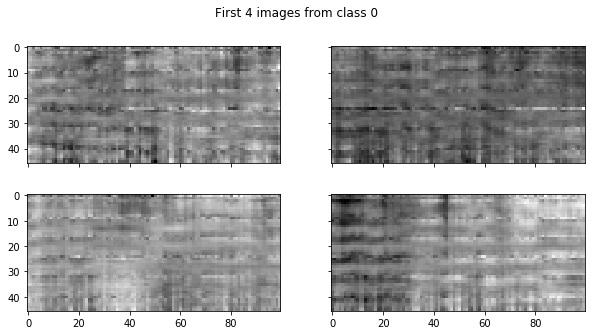

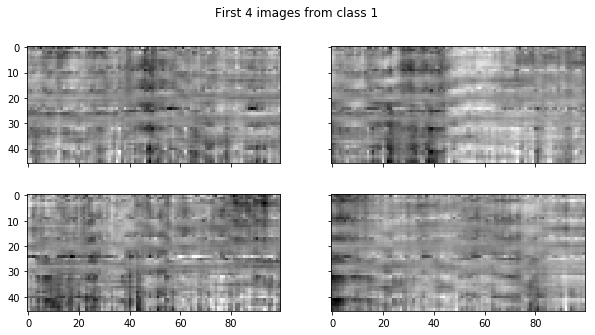

In [7]:
plot_images(x, y, 0)
plot_images(x, y, 1)

The last thing that we have to do is to resize the image to be 46x46 as that is the the shape used in the two papers that use this patients data. Kaitlyn contacted Ewan Nurse where he stated that bilinear interpolation was used in the `SciPy` package to resize the image. However, `scipy.misc.imresize` is deprecated and will be removed in `SciPy 1.3.0` so it is suggested to use the `Python Imaging Library (PIL)`. This functionality is implemented in the following code segment:

In [8]:
from PIL import Image

'''
Iterates through every image, reshapes it to 46x100
and then resize using linear interpolation to
46x46 and then flattens the image again
'''
resized_x = np.zeros((x.shape[0], 46 * 46))
for i in range(x.shape[0]):
    two_d_arr = x[i, :].reshape(46, 100)
    im = Image.fromarray(two_d_arr)
    im = im.resize((46, 46), resample = Image.BILINEAR)
    resized_x[i, :] = np.array(im).reshape((46 * 46))

Now, we can plot the images using the previously defined function to see how the resized images look.

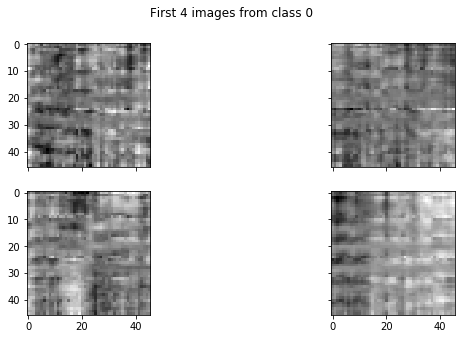

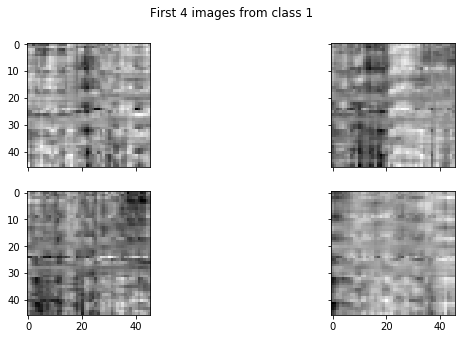

In [9]:
plot_images(resized_x, y, 0, image_shape = (46, 46))
plot_images(resized_x, y, 1, image_shape = (46, 46))

One more thing that is interesting to do is to convert the data into spikes. This is the data that will be inputed to the network that will be deployed in RANC. The following function will be able to take in real data and output data encoded into spikes.

In [10]:
def generate_rate_burst_code(pixel, num_bins):
    num_spikes = int(round(num_bins*pixel))
    return [1]*num_spikes + [0]*(num_bins-num_spikes)

In [11]:
def positivify_data(original_data, n_bins):
    positive_data = np.zeros((original_data.shape[0], n_bins, original_data.shape[1]))

    '''
    Will iterate through every sample and make it positive
    '''
    for i in range(original_data.shape[0]):
        '''
        Using the min value to move every value to be non-negative, and then using the
        max value to normalize all data from 0 - 1
        '''
        min_val = np.min(original_data[i, :])
        if min_val > 0:
            min_val = 0
        max_val = np.max(original_data[i, :])
        positive_data[i, :] = (original_data[i, :] - min_val) / (max_val - min_val)

    return positive_data

In [12]:
def ranc_encode_burst_rate(original_data, n_bins, input_shape):
    '''
    Creating a new numpy array which will contain the encoded data
    '''
    if len(original_data.shape) != 2:
        print("ranc_encode_burst_rate: Data must have a dimension of 2. Given dimension of {}. Exiting".format(original_data.shape))
        exit(1)

    encoded_data = positivify_data(original_data, n_bins)

    '''
    Will itereate through every pixel of every sample and create a spike train.
    '''
    for i in range(original_data.shape[0]):
        for j in range(original_data.shape[1]):
            encoded_data[i, :, j] = generate_rate_burst_code(encoded_data[i, 0, j], n_bins)

    encoded_data = encoded_data.reshape(encoded_data.shape[0], n_bins, input_shape[0], input_shape[1])
    return encoded_data

In [13]:
encoded_resized_x = ranc_encode_burst_rate(resized_x, 1, (46, 46))

This data is just converted to be values between 0 - 1. This can be thought of as the probablity of their being a spike for that given pixel. The neural network that is deployed on RANC will first be trained on the floating point data between 0 - 1, but then while executing on the test data the data will be rounded to either 1 or 0, where 1 represents a spike and a 0 represents no spike. If we round the array that we just created, we can observe the impact of the binarized constraint employed by the RANC architecture. In these figures, black means no spike, and white means spike.

plot_images: dimension mismatch between image_shape ((46, 46)) and data (1). Exiting
plot_images: dimension mismatch between image_shape ((46, 46)) and data (1). Exiting


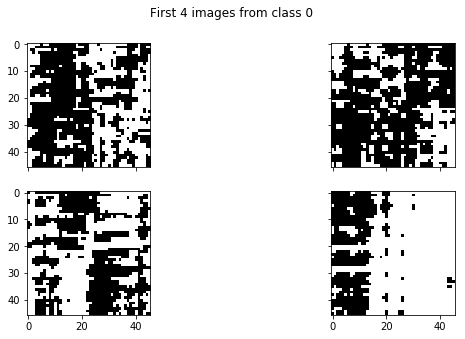

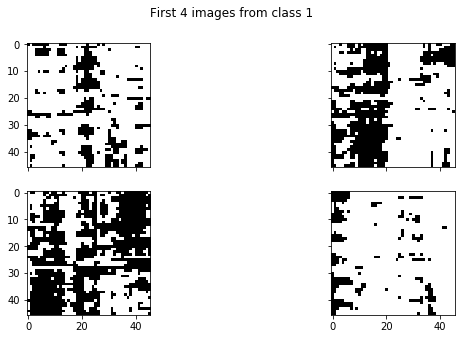

In [14]:
plot_images(np.round(encoded_resized_x), y, 0, image_shape = (46, 46))
plot_images(np.round(encoded_resized_x), y, 1, image_shape = (46, 46))

As one can see, a lot of information is lost this way. This makes it clear that if we were to use more ticks in order to represent the images, we would have much higher accuracies. This is seen by the results in Yepes et al. "Improving Classification Accuracy of Feedforward Neural Networks for Spiking Neuromorphic Chips".

### 3.0 Keras Implementation

Now that we have all of the data that we currently need, we will use the Keras library in order to create four neural network models and determine the effectivenes that they have on the data that was prepared in the previous section. Our first step is to seperate the data into a testing and training set. I split it up so we are using 14.5% of the data as the testing data set. This seems to be more or less consistent with previous work. When actually comparing it would be necessary to ensure that we using the exact same number. After splitting up the data using `sklearn.model_selection.train_test_split`, we will use the `keras.to_categorical` function to convert the labels into one-hot encoded vectors.

In [15]:
from sklearn.model_selection import train_test_split
import keras

x_train, x_test, y_train, y_test = train_test_split(resized_x, y, test_size = 0.145, shuffle = True)
labels = [int(label) for label in y_test] # Need to keep track of the labels when we put the network on the simulator
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

Using TensorFlow backend.


It is now time to create the models using Keras. The first network that I am using is a fully-connected neural network. This was simply the easiest to create and doesn't hold any signifigance with the literature. This network will contain one hidden layer of 128 ReLU neurons.   

In [16]:
fc_model = keras.models.Sequential()
fc_model.add(keras.layers.Dense(units = 128, activation='relu', input_dim = 46 * 46))
fc_model.add(keras.layers.Dense(units = 2, activation='softmax'))

fc_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Next I will create the two-dimensional convolutional neural network which matches the architecture used in Nurse et al. "Decoding EEG and LFP Signals using Deep Learning: Heading TrueNorth".

In [17]:
two_d_conv_model = keras.models.Sequential()
two_d_conv_model.add(keras.layers.Reshape((46, 46, 1), input_shape=(46 * 46,)))
two_d_conv_model.add(keras.layers.Conv2D(40, kernel_size=(5, 5), strides=(1, 1), activation='sigmoid'))
two_d_conv_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
two_d_conv_model.add(keras.layers.Conv2D(100, kernel_size=(5, 5), strides=(1, 1), activation='sigmoid'))
two_d_conv_model.add(keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
two_d_conv_model.add(keras.layers.Flatten())
two_d_conv_model.add(keras.layers.Dense(units = 500, activation='sigmoid'))
two_d_conv_model.add(keras.layers.Dense(units = 2, activation='softmax'))

two_d_conv_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Next, I will create a one-dimensional convolutiona neural network. This is more intuitive to me as the temporal correlation of  the data seems much stronger than the spatial correlation. A one-dimensional convolutional neural network will learn a filter that shifts over the time-domain in order to create output feature maps. Other than the fact that this neural network is using one-dimensional convolution, the design decisions are rather arbitrary. It would be good to play with these numbers to create a better model.

In [18]:
one_d_conv_model = keras.models.Sequential()
one_d_conv_model.add(keras.layers.Reshape((46, 46), input_shape=(46 * 46,)))
one_d_conv_model.add(keras.layers.Conv1D(32, kernel_size=(5), strides=(1), activation='relu'))
one_d_conv_model.add(keras.layers.Flatten())
one_d_conv_model.add(keras.layers.Dense(units = 100, activation='relu'))
one_d_conv_model.add(keras.layers.Dense(units = 2, activation='softmax'))
one_d_conv_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Now that we have defined all of our conventional models (ones that can't be deployed on RANC), we can run these models on the data that we have prepared. Before we do that, Keras makes it easy to create a figure showing the training accuracy as we train the network. The following function will allow us to easily create this figure:

In [19]:
def plot_history(history, title = 'Accuracy vs. Epoch'):
    '''
    Creates a plot of the training accuracy from a history object from a training
    session

    Arguments:
    history - A history object which contains the training accuracy.

    Keyword Arguments:
    filename - The path of the image to be saved to

    '''
    plt.figure()
    plt.plot(history.history['acc'])
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training'], loc='lower right')
    axes = plt.gca()
    axes.set_ylim([0, 1.1])


Now, onto training the models!

In [20]:
'''
Training and testing the fully-connected network
'''
print("Training FC Network")
fc_history = fc_model.fit(x_train, y_train, epochs=100, batch_size=32)
fc_test_loss, fc_test_accuracy = fc_model.evaluate(x_test, y_test)


'''
Training and testing the 1d convolutional network
'''
print("Training 1D Conv Network")
one_d_conv_history = one_d_conv_model.fit(x_train, y_train, epochs=100, batch_size=32)
one_d_conv_test_loss, one_d_conv_test_accuracy = one_d_conv_model.evaluate(x_test, y_test)

'''
Training and testing the 2d convolutional network
'''
print("Training 2D Conv Network")
two_d_conv_history = two_d_conv_model.fit(x_train, y_train, epochs=100, batch_size=32)
two_d_conv_test_loss, two_d_conv_test_accuracy = two_d_conv_model.evaluate(x_test, y_test)


Training FC Network
Epoch 1/100
948/948 [==============================] - 7s 7ms/step - loss: 3.9963 - acc: 0.6498
Epoch 2/100
948/948 [==============================] - 0s 112us/step - loss: 2.3189 - acc: 0.7848
Epoch 3/100
948/948 [==============================] - 0s 121us/step - loss: 1.4176 - acc: 0.8397
Epoch 4/100
948/948 [==============================] - 0s 103us/step - loss: 0.9111 - acc: 0.8829
Epoch 5/100
948/948 [==============================] - 0s 101us/step - loss: 0.4345 - acc: 0.9399
Epoch 6/100
948/948 [==============================] - 0s 104us/step - loss: 0.3261 - acc: 0.9420
Epoch 7/100
948/948 [==============================] - 0s 106us/step - loss: 0.2103 - acc: 0.9652
Epoch 8/100
948/948 [==============================] - 0s 102us/step - loss: 0.2491 - acc: 0.9673
Epoch 9/100
948/948 [==============================] - 0s 102us/step - loss: 0.1904 - acc: 0.9599
Epoch 10/100
948/948 [==============================] - 0s 103us/step - loss: 0.1728 - acc: 0.9715
E

948/948 [==============================] - 0s 105us/step - loss: 0.0170 - acc: 0.9989
Epoch 84/100
948/948 [==============================] - 0s 100us/step - loss: 0.0170 - acc: 0.9989
Epoch 85/100
948/948 [==============================] - 0s 104us/step - loss: 0.0170 - acc: 0.9989
Epoch 86/100
948/948 [==============================] - 0s 101us/step - loss: 0.0170 - acc: 0.9989
Epoch 87/100
948/948 [==============================] - 0s 102us/step - loss: 0.0170 - acc: 0.9989
Epoch 88/100
948/948 [==============================] - 0s 100us/step - loss: 0.0170 - acc: 0.9989
Epoch 89/100
948/948 [==============================] - 0s 105us/step - loss: 0.0170 - acc: 0.9989
Epoch 90/100
948/948 [==============================] - 0s 100us/step - loss: 0.0170 - acc: 0.9989
Epoch 91/100
948/948 [==============================] - 0s 102us/step - loss: 0.0170 - acc: 0.9989
Epoch 92/100
948/948 [==============================] - 0s 100us/step - loss: 0.0170 - acc: 0.9989
Epoch 93/100
948/948 [=

948/948 [==============================] - 0s 127us/step - loss: 1.1544e-04 - acc: 1.0000
Epoch 64/100
948/948 [==============================] - 0s 132us/step - loss: 1.1105e-04 - acc: 1.0000
Epoch 65/100
948/948 [==============================] - 0s 146us/step - loss: 1.0741e-04 - acc: 1.0000
Epoch 66/100
948/948 [==============================] - 0s 148us/step - loss: 1.0434e-04 - acc: 1.0000
Epoch 67/100
948/948 [==============================] - 0s 146us/step - loss: 9.9936e-05 - acc: 1.0000
Epoch 68/100
948/948 [==============================] - 0s 125us/step - loss: 9.6462e-05 - acc: 1.0000
Epoch 69/100
948/948 [==============================] - 0s 129us/step - loss: 9.3148e-05 - acc: 1.0000
Epoch 70/100
948/948 [==============================] - 0s 132us/step - loss: 8.9864e-05 - acc: 1.0000 0s - loss: 9.4307e-05 - acc: 1.00
Epoch 71/100
948/948 [==============================] - 0s 130us/step - loss: 8.6947e-05 - acc: 1.0000
Epoch 72/100
948/948 [==============================

948/948 [==============================] - 0s 331us/step - loss: 0.0070 - acc: 1.0000
Epoch 44/100
948/948 [==============================] - 0s 327us/step - loss: 0.0060 - acc: 1.0000
Epoch 45/100
948/948 [==============================] - 0s 328us/step - loss: 0.0051 - acc: 1.0000
Epoch 46/100
948/948 [==============================] - 0s 330us/step - loss: 0.0046 - acc: 1.0000
Epoch 47/100
948/948 [==============================] - 0s 331us/step - loss: 0.0044 - acc: 1.0000
Epoch 48/100
948/948 [==============================] - 0s 370us/step - loss: 0.0040 - acc: 1.0000
Epoch 49/100
948/948 [==============================] - 0s 332us/step - loss: 0.0036 - acc: 1.0000
Epoch 50/100
948/948 [==============================] - 0s 332us/step - loss: 0.0031 - acc: 1.0000
Epoch 51/100
948/948 [==============================] - 0s 335us/step - loss: 0.0028 - acc: 1.0000
Epoch 52/100
948/948 [==============================] - 0s 332us/step - loss: 0.0027 - acc: 1.0000
Epoch 53/100
948/948 [=

Now we have the training history, loss on the testing set, and accuracy on the testing set. We can now put these into nice figures using the `plot_history` function defined above.

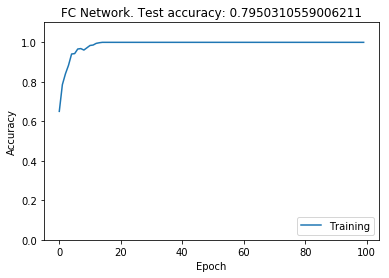

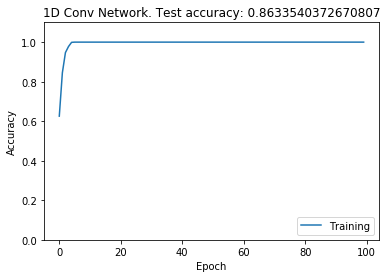

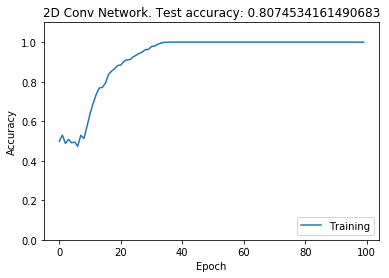

In [21]:
plot_history(fc_history, title = "FC Network. Test accuracy: {}".format(fc_test_accuracy))
plot_history(one_d_conv_history, title = "1D Conv Network. Test accuracy: {}".format(one_d_conv_test_accuracy))
plot_history(two_d_conv_history, title = "2D Conv Network. Test accuracy: {}".format(two_d_conv_test_accuracy))

Now, this is all fine and dandy but we want to actually train a network that will be compatable with RANC. This is where we use the `tealayers` library that Ruben developed. This library allows the constraints of RANC to be taken into account while training. To use this library, change to the `software/tealayers` directory and run `pip install .`. Now, if you run `pip freeze` you should see `tealayers` as an available library. Now that the library is downloaded, the first thing we have to do is get the data in the correct representation using the `ranc_encode_burst_rate` function used before. We then have to reshape the data to cooperate with the library. The `tealayers` library we will be using expects input data to be in the shape `(number_of_images, number_of_spikes_per_image, x_dim, y_dim)`. More information on the specifics of the `tealayers` library can be found in the folder: `<TODO: Port TeaLearningTutorial>`

In [22]:
x_train_encoded = ranc_encode_burst_rate(x_train, 1, (46, 46)).reshape(x_train.shape[0], 1, 46, 46)
x_test_encoded = ranc_encode_burst_rate(x_test, 1, (46, 46)).reshape(x_test.shape[0], 1, 46, 46)

It is also important to think of how the network is going to be organized and how we can implement that using the `tealayers` library. The first thing to do is to create a sequential model in Keras, which is the same way we created the other models.

In [23]:
from tealayers import Tea, AdditivePooling

tea_model = keras.models.Sequential()

Now, we must be cognisant of the fan-in and fan-out of the RANC cores. By default, each core can take in 256 inputs (axons) which can be connected through a synapse to any of the 256 neurons on the core. Therefore, we choose to use 16x16 grids of the image to be the input to a given core. I also chose for there to be a stride of 12 so there is some overlap between the inputs. The `tealayers` library will automatically zeropad the input for us so that it fits nicely with the kernel area and the stride specified. For this particular example, the input is 46x46. To comply with the kernel size and stride that we chose, the input will be zero padded to a size of 52x52. Now, we can visually inspect that we will need 16 16x16 input grids with a stride of 12 to slide over the entire image. Now, we must choose the number of neurons that we will have active in a given core. We must decrease the size of the data as it propagates through the network so we can eventually feed it to a single core which will produce the predictions of the model. This means that we cannot use all 256 neurons of the cores (as the data would grow rather than shrink). I arbitrarlity chose to use 64 neurons, which means that we will have 64 \* 16 = 1024 outputs for the next hidden layer. The first hidden layer is defined as follows:

In [24]:
'''
Creating 16 cores each with 64 neurons. Each will receive an input of size 16x16. The inputs are created using a stride of 12x12
'''
tea_model.add(Tea([64] * 16, [16, 16], [12, 12], activation = 'sigmoid'))

Now the output of the first hidden layer is 1024 elements. Remember, we would like to eventually decrease this number to 256 so it can go into a single output core. Therefore, I create the next layer using 4 cores each with 64 neurons. Because 256 \* 4 = 1024, this is sufficient for the entire output of the first hidden layer.

In [25]:
'''
Creating 4 cores each with 64 neurons. Each will receive the concatenated output of four cores from the previous layer.
'''
tea_model.add(Tea([64] * 4, 256, 256, activation = 'sigmoid'))

Now, we have 4 cores each with 64 outputs. This means that the second hidden layer has an output of 4 \* 64 = 256 elements. This is small enough to be the input of a single core, which we will call the output core. Note that, similar to an output layer in a conventional neural network, the output core will have neurons that correspond to different classes. In this particular example, we have two classes, so the neurons alternate between corresponding to class zero and class one. This places a constraint on the number of neurons one can uses in the output core, as it has to be divisible by the number of classes. Because we have two classes, we can use all 256 neurons. However, if we were implementing a network for MNIST which has 10 classes, we would only use 250 neurons so we could have an equal number of neurons for every class. We will create the output core as follows:

In [26]:
'''
Creating the output core which uses all 256 neurons. 
This core receives the concatenated output of the four cores from the previous layer.
'''
tea_model.add(Tea([256], 256, 256, activation = 'sigmoid'))

The last things that we have to do are just for training purposes and are not a part of the network that will actually be deployed on RANC. The Additive Pooling layer is a layer which adds all outputs of neurons corresponding to a particular class. This is useful because we will now have a single value for every class which corresponds to the level the network believes the inputs belongs to a particular class. The output of the Additive Pooling layer can then be placed into a softmax function, which is used to convert the output of the Additive Pooling layer into probabilities that the input corresponds to the various classes. We then compile the model in which we define the loss function and optimizer which we have done for all the other models. 

In [27]:
'''
Creating the additive pooling layer which is used just in training to add the output of all the
neurons corresponding to a specific class. In the output core in this particular example,
we have two classes, so the first neuron corresponds to class zero, the second neurons corresponds 
to class one, the third corresponds to class zero, etc. In this layer, these outputs are summed
together so we only have two outputs, one for class zero and one for class one.
'''
tea_model.add(AdditivePooling(2))
tea_model.add(keras.layers.Activation('softmax'))
tea_model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

We have now created a RANC compatable network using the `tealayers` library. This implemnentation in total uses 21 RANC cores and uses 2 hidden layers and one output layer. Now, before we train, it can be helpful to use Keras `callbacks` in order to visualize wqhat is happening in the network whilst training. There are currently two that I enjoy using. The first is one that we created defined in `rancutils/tealearning` and it is called `ConnectionHistory`. This callback allows a user to see how the connections in the cores vary as the network is trained. Below is the creation of the `ConnectionHistory` callback to record the connections in layer 0 core 0, layer 1 core 0, and layer 2 core 0 and store those images in `connections/`:

In [28]:
from rancutils.tealearning import ConnectionHistory

cb = ConnectionHistory([(0, 0), (1, 0), (2, 0)], 'connections/', round_connections = True, make_gif = True)

The other callback that is helpful is the `TensorBoard` callback built into Keras which is supported by Google and allows lots of visualizations (As well as basically the same information provided by `ConnectionHistory` but I didn't know that until after I wrote the callback :-( ). In the following line, I store `TensorBoard` calls in `logs/` which can be visualized by running the command `tensorboard --logdir path_to_current_dir/logs`:

In [29]:
tensorboard = keras.callbacks.TensorBoard(log_dir = './logs', histogram_freq = 10, write_grads = True, write_images = True)

Now we have the RANC compatable network and data. We can train the network like any other network defined in Keras.

Train on 948 samples, validate on 161 samples
Will analyze the following cores: [(0, 0), (1, 0), (2, 0)]
Epoch 1/100
948/948 [==============================] - 2s 3ms/step - loss: 1.3396 - acc: 0.5443 - val_loss: 1.3682 - val_acc: 0.4410
Epoch 2/100
948/948 [==============================] - 0s 522us/step - loss: 0.8680 - acc: 0.5654 - val_loss: 1.0666 - val_acc: 0.4969
Epoch 3/100
948/948 [==============================] - 0s 379us/step - loss: 0.7515 - acc: 0.5591 - val_loss: 0.8262 - val_acc: 0.5652
Epoch 4/100
948/948 [==============================] - 0s 377us/step - loss: 0.6494 - acc: 0.6245 - val_loss: 0.8105 - val_acc: 0.5342
Epoch 5/100
948/948 [==============================] - 0s 391us/step - loss: 0.5907 - acc: 0.6793 - val_loss: 0.9485 - val_acc: 0.5342
Epoch 6/100
948/948 [==============================] - 0s 378us/step - loss: 0.5210 - acc: 0.7542 - val_loss: 0.9172 - val_acc: 0.5901
Epoch 7/100
948/948 [==============================] - 0s 370us/step - loss: 0.4509 - a

948/948 [==============================] - 0s 374us/step - loss: 0.0476 - acc: 0.9821 - val_loss: 1.3619 - val_acc: 0.6770
Epoch 61/100
948/948 [==============================] - 0s 421us/step - loss: 0.0614 - acc: 0.9757 - val_loss: 1.0756 - val_acc: 0.7329
Epoch 62/100
948/948 [==============================] - 0s 377us/step - loss: 0.0381 - acc: 0.9895 - val_loss: 1.1515 - val_acc: 0.6832
Epoch 63/100
948/948 [==============================] - 0s 384us/step - loss: 0.0901 - acc: 0.9641 - val_loss: 1.0148 - val_acc: 0.6646
Epoch 64/100
948/948 [==============================] - 0s 406us/step - loss: 0.0871 - acc: 0.9694 - val_loss: 0.8687 - val_acc: 0.7391
Epoch 65/100
948/948 [==============================] - 0s 392us/step - loss: 0.0401 - acc: 0.9810 - val_loss: 1.0052 - val_acc: 0.7267
Epoch 66/100
948/948 [==============================] - 0s 504us/step - loss: 0.0542 - acc: 0.9821 - val_loss: 1.0336 - val_acc: 0.7516
Epoch 67/100
948/948 [==============================] - 0s 40

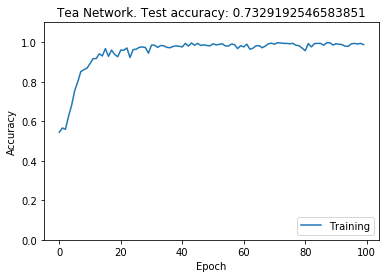

In [30]:
tea_history = tea_model.fit(x_train_encoded, y_train, epochs=100, batch_size=32, verbose = 1, validation_data=(x_test_encoded, y_test), callbacks = [cb, tensorboard])
tea_loss, tea_accuracy = tea_model.evaluate(x_test_encoded, y_test)
plot_history(tea_history, title = "Tea Network. Test accuracy: {}".format(tea_accuracy))

We have now trained a RANC deployable network on the EEG data!

### 3.0 Mapping to Simulator and Hardware

To map to the software simulator, we can use the `rancutils` library. This can be found and installed using `pip` the same way that you installed the `tealayers` library. The first thing that we have to do is create a function that will output the weights and biases of the model. This will be done in this hardcoded way at first but I will try to work on it later. First, we can see what types of layers are in our model by running the following code:

In [31]:
[weight.name for layer in tea_model.layers for weight in layer.weights]

['tea_1/connections0:0',
 'tea_1/bias0:0',
 'tea_1/connections1:0',
 'tea_1/bias1:0',
 'tea_1/connections2:0',
 'tea_1/bias2:0',
 'tea_1/connections3:0',
 'tea_1/bias3:0',
 'tea_1/connections4:0',
 'tea_1/bias4:0',
 'tea_1/connections5:0',
 'tea_1/bias5:0',
 'tea_1/connections6:0',
 'tea_1/bias6:0',
 'tea_1/connections7:0',
 'tea_1/bias7:0',
 'tea_1/connections8:0',
 'tea_1/bias8:0',
 'tea_1/connections9:0',
 'tea_1/bias9:0',
 'tea_1/connections10:0',
 'tea_1/bias10:0',
 'tea_1/connections11:0',
 'tea_1/bias11:0',
 'tea_1/connections12:0',
 'tea_1/bias12:0',
 'tea_1/connections13:0',
 'tea_1/bias13:0',
 'tea_1/connections14:0',
 'tea_1/bias14:0',
 'tea_1/connections15:0',
 'tea_1/bias15:0',
 'tea_1/w0:0',
 'tea_1/w1:0',
 'tea_1/w2:0',
 'tea_1/w3:0',
 'tea_1/w4:0',
 'tea_1/w5:0',
 'tea_1/w6:0',
 'tea_1/w7:0',
 'tea_1/w8:0',
 'tea_1/w9:0',
 'tea_1/w10:0',
 'tea_1/w11:0',
 'tea_1/w12:0',
 'tea_1/w13:0',
 'tea_1/w14:0',
 'tea_1/w15:0',
 'tea_2/connections0:0',
 'tea_2/bias0:0',
 'tea_2/con

We can see what layer they are a part of by the `tea_<layer_id>/` at the beggining. Now, we can see that we have 16 connections matrices and 16 biases for the first layer, 4 connections matrices and 4 biases for the second layer, and 1 connection and 1 bias for the last layer. This is what can be converted to the RANC architecture (specifically, the connections are converted to synapses and the biases are converted to leaks). Now, we need to extract this information so we can create the software and hardware configuration files.

In [32]:
def get_connections_and_biases(model, num_layers):
    
    weights = model.get_weights()
    names = [weight.name for layer in model.layers for weight in layer.weights]
    connections = [[] for i in range(num_layers)]
    biases = [[] for i in range(num_layers)]
    
    for weight, name in zip(weights, names):
        layer_id = int(name.split('/')[0].split('_')[1]) - 1
        data_type = name.split('/')[1]

        if 'connection' in data_type:
            connections[layer_id].append(weight)
        elif 'bias' in data_type:
            biases[layer_id].append(weight)
        
    return connections, biases

Now, we can use this in another function which will actually generate the input files for the simulator.

In [33]:
from rancutils.simulator import simulator_conversion
from rancutils.tealearning import create_cores, create_packets
from rancutils.tealearning import tea_weight_initializer

def output_for_simulator(model, x_test, num_layers, labels, image_shape):
    connections, biases = get_connections_and_biases(model, num_layers)
    
    weights = []
    for layer in connections:
        w = []
        for partition in layer:
            w.append(tea_weight_initializer(partition.shape))
        weights.append(w)

    for layer_num, (layer_biases, layer_connections) in enumerate(zip(biases, connections)):
        for partition_num, (partition_biases, partition_connections) in enumerate(zip(layer_biases, layer_connections)):
            biases[layer_num][partition_num] = np.round(partition_biases).astype(int)
            connections[layer_num][partition_num] = np.clip(np.round(partition_connections), 0, 1).astype(int)

    cores = create_cores(connections, weights, biases)
    packets = create_packets(x_test, [16, 16], [12, 12], 1, image_shape)
    simulator_conversion(cores, packets=packets, labels=labels)

Now, we can simply input our tea model into this function and we will have the files that define our network on the software simulator.

In [34]:
output_for_simulator(tea_model, x_test_encoded, 3, labels, (46, 46))

You have succesfully generated outputs for the simulator. There should now be a `labels.txt` and a `input.txt` file in this directory. You can take these files, put them in the `data` direction in the Software Simulator project. Then, you can run the following command to see the first 10 predictions on the simulator: `python driver.py ../data/eeg/input.txt ../data/eeg/labels.txt ../data/eeg/output.txt -t 11 -r 1 --output_cores 20 0 --neurons_in_output 256 --num_classes 2 --num_layers 3 --output_class_votes`. This should produce the following output: 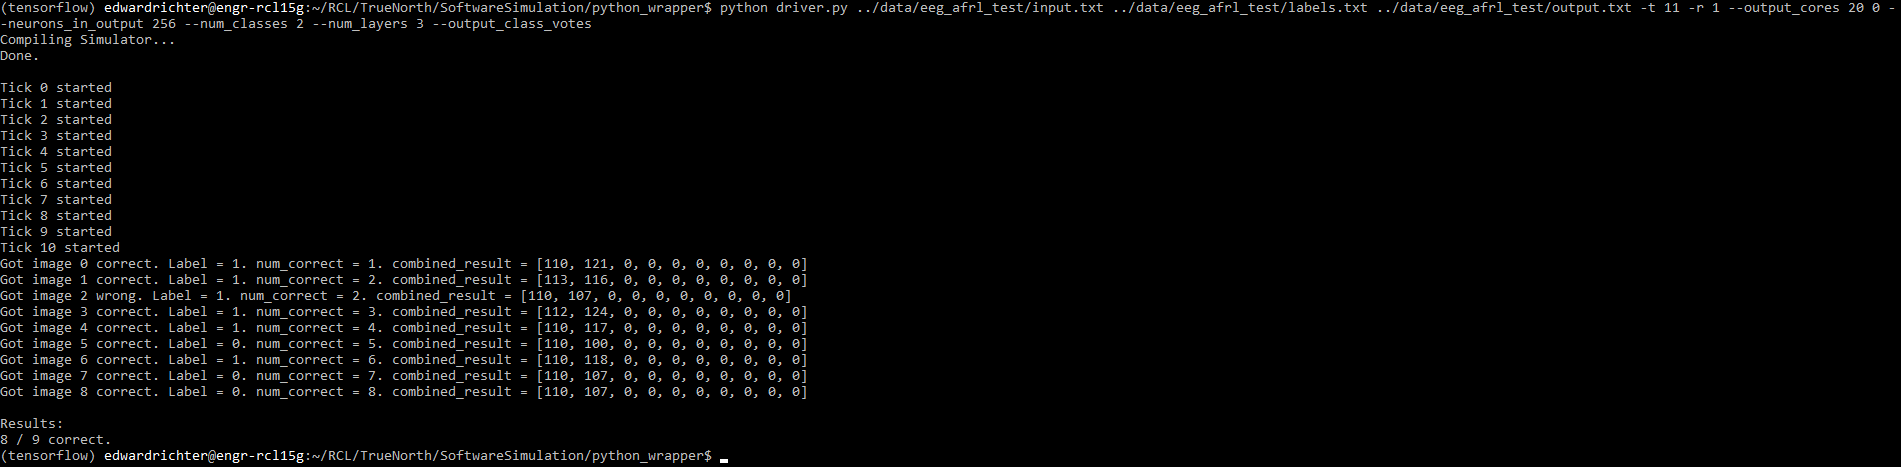 We can then use the following code to see if these predictions match the the training code. 

In [35]:
first_predictions = np.argmax(tea_model.predict(x_test_encoded[0:9]), axis = 1)
first_labels = np.argmax(y_test[0:9], axis = 1)

for prediction, label in zip(first_predictions, first_labels):
    print("Prediction: {}, Label: {}, Correct: {}".format(prediction, label, prediction == label))

Prediction: 1, Label: 1, Correct: True
Prediction: 1, Label: 1, Correct: True
Prediction: 0, Label: 1, Correct: False
Prediction: 1, Label: 1, Correct: True
Prediction: 1, Label: 1, Correct: True
Prediction: 0, Label: 0, Correct: True
Prediction: 1, Label: 1, Correct: True
Prediction: 0, Label: 0, Correct: True
Prediction: 0, Label: 0, Correct: True


We can even go a step further and create a copy of the model where the output is the output of the `AdditivePooling` layer. This will let us verify that the exact same neurons spiked in the simulator and in the trainig code.

In [36]:
from keras.models import Model

additive_pooling_model = Model(inputs=tea_model.input,
                            outputs=tea_model.get_layer("additive_pooling_1").output)
additive_pooling_output = additive_pooling_model.predict(x_test_encoded[0:9])
print("Output of additive pooling layer for first 9 images:")
print(additive_pooling_output)

Output of additive pooling layer for first 9 images:
[[110. 121.]
 [113. 116.]
 [110. 107.]
 [112. 124.]
 [110. 117.]
 [110. 100.]
 [110. 118.]
 [110. 107.]
 [110. 107.]]


Now it is time to target the hardware. The only thing we are going to have to do is create an `output_for_hardware` similar to the `output_for_simulator` function defined above.

In [37]:
from rancutils.hardware import hardware_conversion

def output_for_hardware(model, x_test, num_layers, labels, image_shape, increment_tick = False):
    connections, biases = get_connections_and_biases(model, num_layers)
    
    weights = []
    for layer in connections:
        w = []
        for partition in layer:
            w.append(tea_weight_initializer(partition.shape))
        weights.append(w)

    for layer_num, (layer_biases, layer_connections) in enumerate(zip(biases, connections)):
        for partition_num, (partition_biases, partition_connections) in enumerate(zip(layer_biases, layer_connections)):
            biases[layer_num][partition_num] = np.round(partition_biases).astype(int)
            connections[layer_num][partition_num] = np.clip(np.round(partition_connections), 0, 1).astype(int)

    cores = create_cores(connections, weights, biases, num_classes = 2)
    packets = create_packets(x_test, [16, 16], [12, 12], 1, image_shape, increment_tick = increment_tick)
    hardware_conversion(cores, packets=packets, labels=labels)

We can now just call this function to create the memory files for the hardware. Note that we want `increment_tick = True`  so the delivery tick is incremented for every image.

In [38]:
output_for_hardware(tea_model, x_test_encoded, 3, labels, (46, 46), increment_tick = True)

This directly should now contain a `csram{core_id}.mem` and a `tc{core_id}.mem` which are the files used to configure the memory in all 21 cores. There is also a `labels.mem` which has all of the labels and an `ir.mem` which is used to program the input router with the packets that represent the data. Next, we need to create the RANC project. The first step is to get all of the projects that have the IP blocks which can create the design. These are located in the following folders: `hardware/rancnetwork`, `hardware/outcomecore`, `hardware/tickgenerator`, `hardware/inputrouter`. Then, create a new Vivado project which targets the Zedboard (xc7z020clg484-1) (Some IP blocks are configured to only be visible when the project is using the Zedboard. This is not necessary and will obviously need to be changed, but it works for now :-) ). Then, go to `Create Block Design`. This will go to an empty block diagram. You can then click on `IP Catalog`, right click on `Vivado Repositories` and click `Add Repository...`. You can then direct the file explorer that opens up to the four projects that you pulled from git. This will make it so you can add these custom IP blocks to your design. Then, go back to the block diagram that you created, and create the following diagram using the IP blocks just imported: 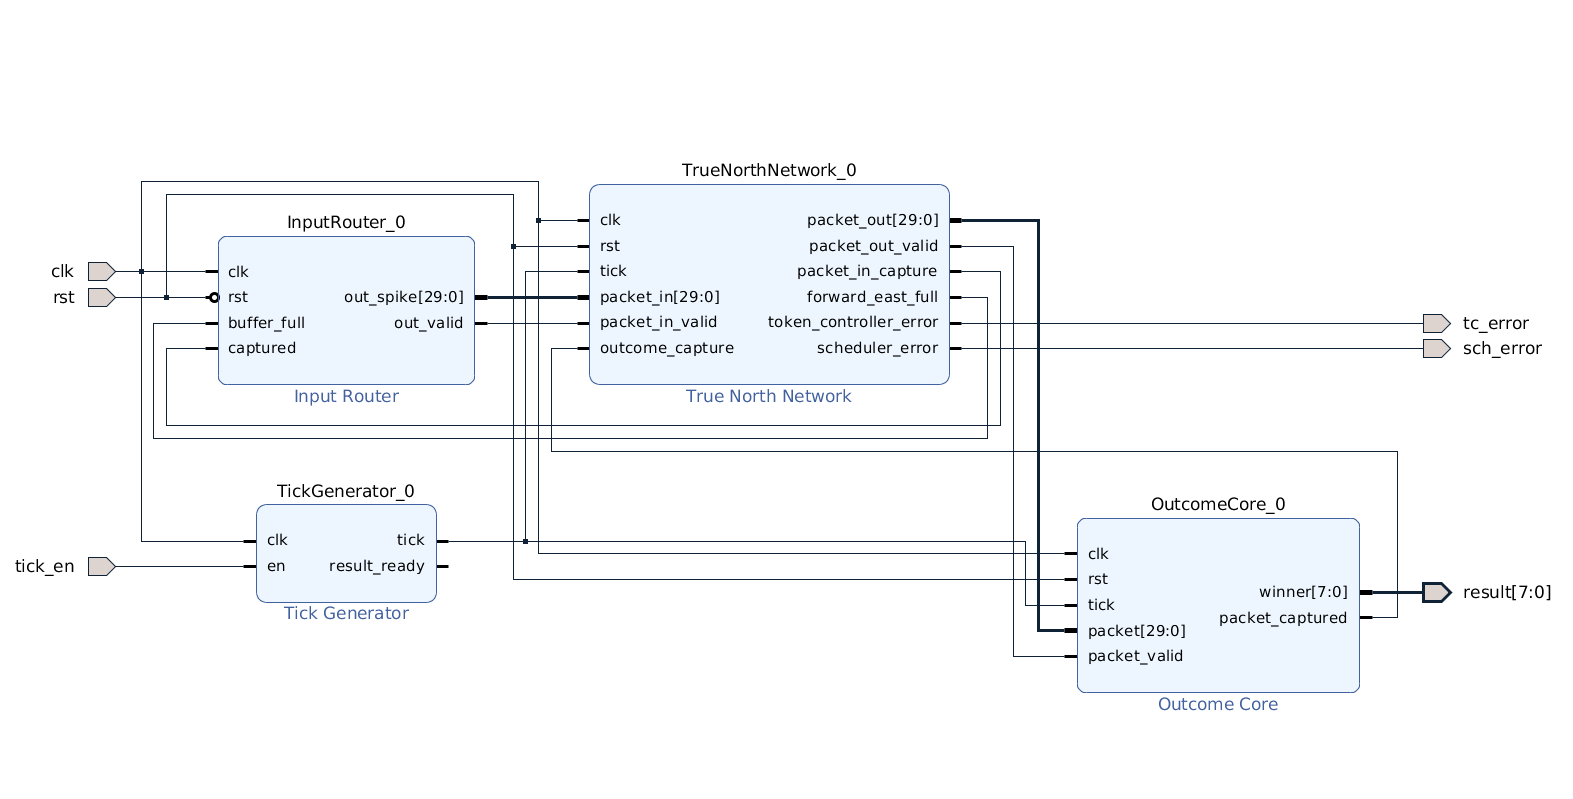 For the EEG data, there are a couple parameters for the blocks that must be changed. This can be done by double-clicking the IP block you want to configure. First, in the input core, we have to state the name of the file and the number of packets. **NOTE: the input router will look in the project for this file. Therefore, you need to import it into your Vivado project as a memory file.** My inputer router was configured to just output the first 15 images of the EEG dataset. This configuration can be seen here: 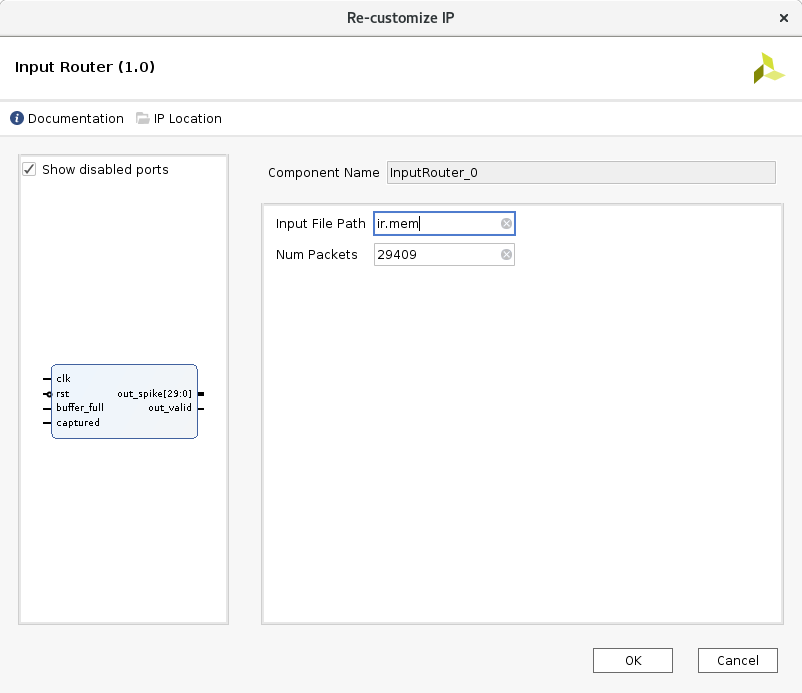 The outcome core must be configured with the number of classes in the application. My configuration can be seen here: 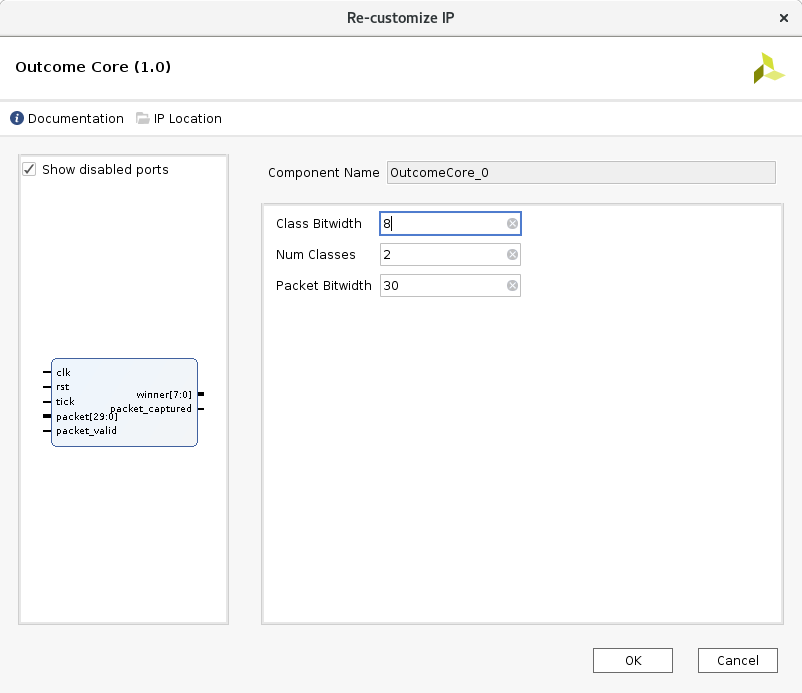 The RANCNetwork IP requires two changes. First, it requires a change in the `Grid Parameters` so we can specify the number of cores we want to use and the coordinates of the output core. This configuration can be seen here: 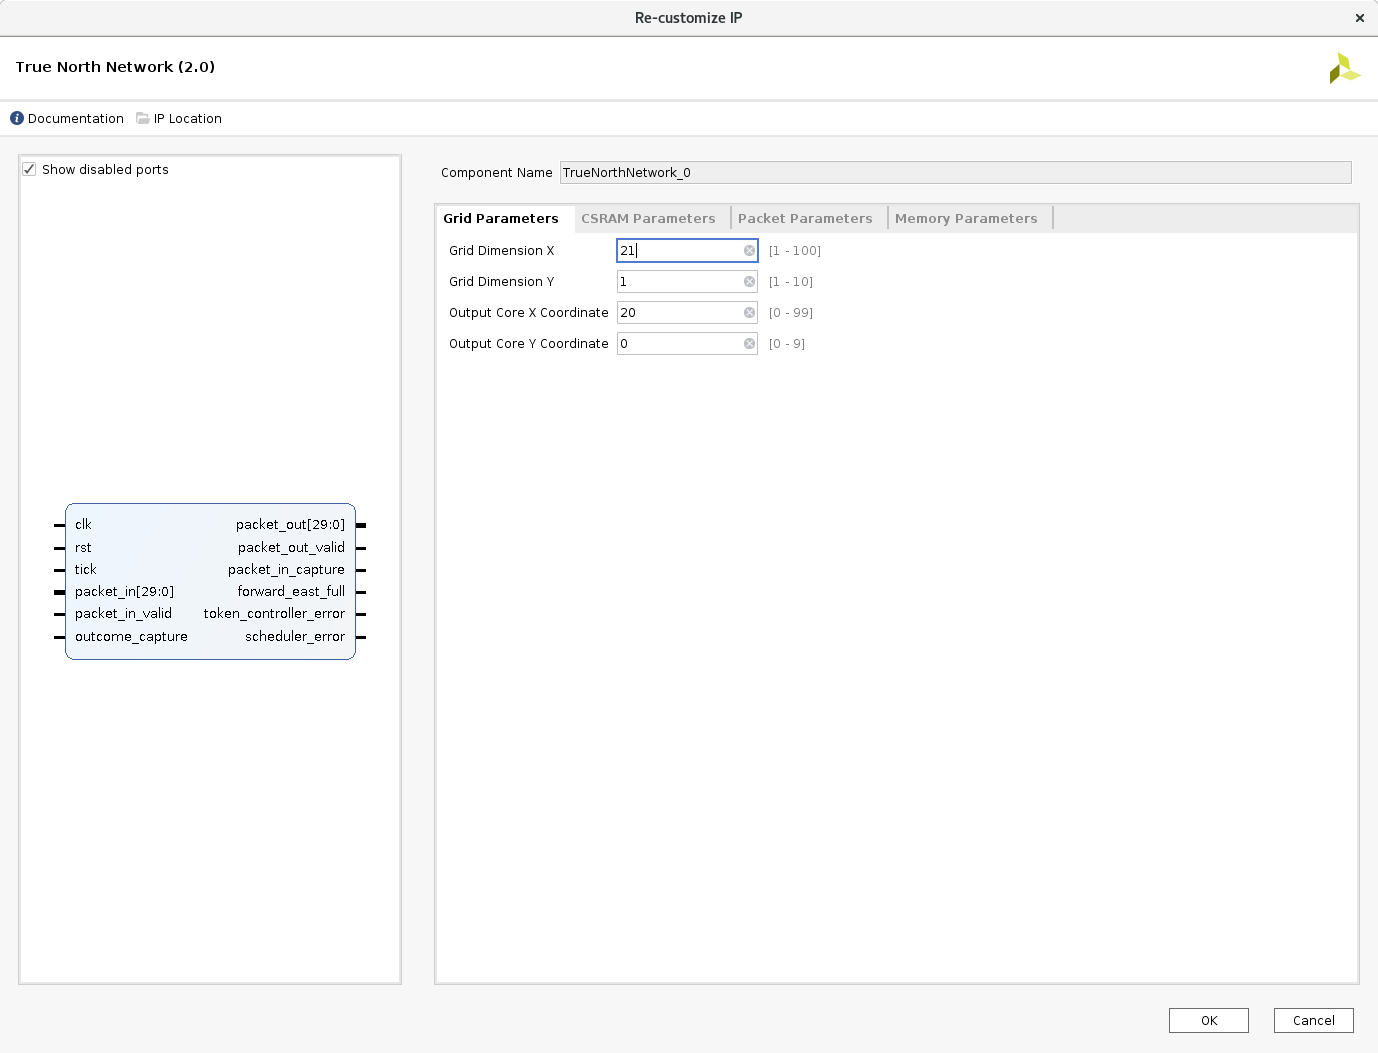 The RANCNetwork IP also requires the user to submit a path to the directory where the `csram{core_id}.mem` and `tc{core_id}.mem` files are located. This is in the `Memory Parameters` pane of the configuration window. The textbox is difficult to see so isntead of putting a screenshot, I will just say that the path that I put in the  `Memory Filepath` textbox is: `/home/edwardrichter/RCL/TrueNorth/eeg/python/`.  Then, generate a HDL wrapper which will allow you to interface with the block design created using a testbench. This can be shown here: 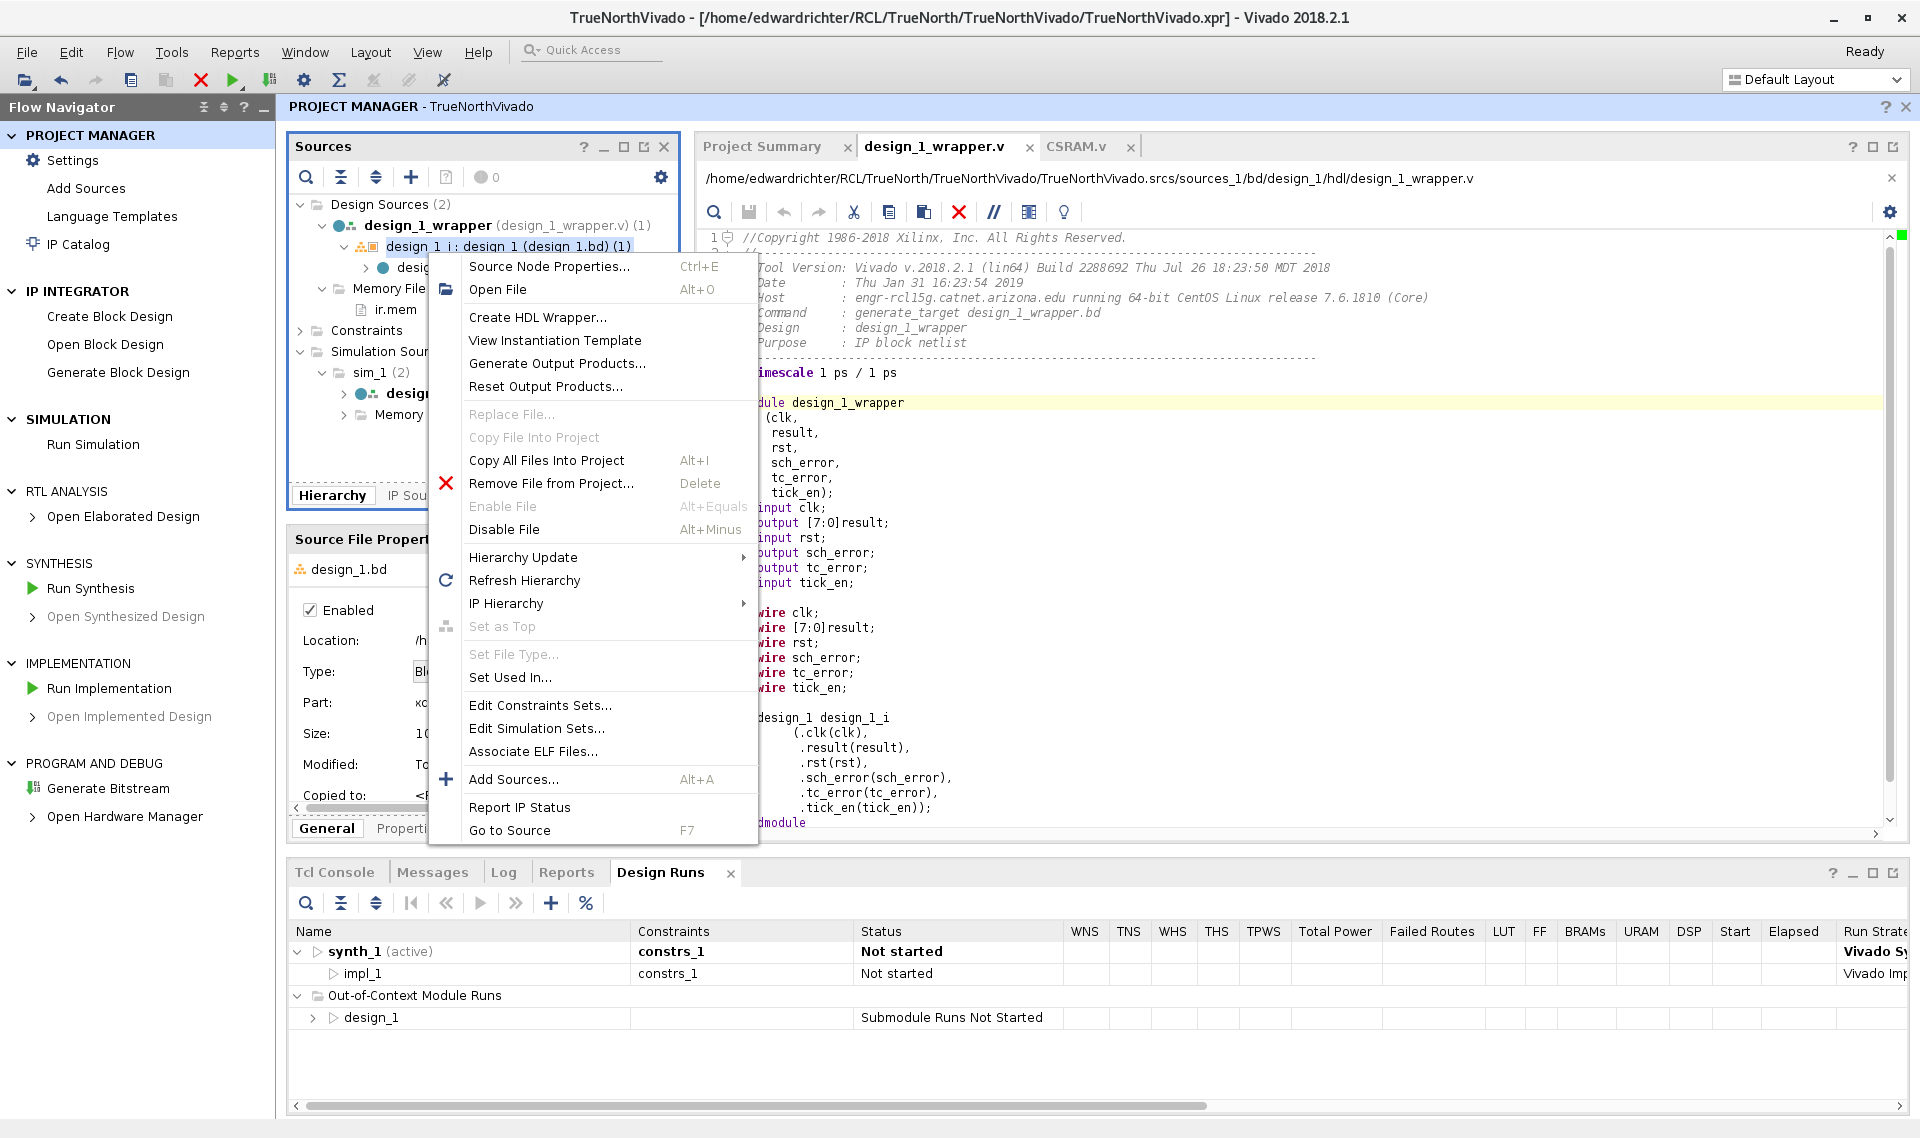 After the wrapper is created, we can interact with the block design using Verilog. This can be done using a very simple testbench shown here:

```
module design_1_tb();

  
    reg clk;
    wire [7:0]result;
    reg rst;
    wire sch_error;
    wire tc_error;
    reg tick_en;
    
    design_1_wrapper design_1_wrapper(
        .clk(clk),
        .result(result),
        .rst(rst),
        .sch_error(sch_error),
        .tc_error(tc_error),
        .tick_en(tick_en)
    );

    always begin
        clk <= ~clk;
        #10;
    end
    
    initial begin
        clk <= 0;
        rst <= 1;
        tick_en <= 0;
        #200;
        rst <= 0;
        tick_en <= 1;
    end


endmodule
```
Then, run the simulation for >240 milliseconds, and you should see a waveform like this: 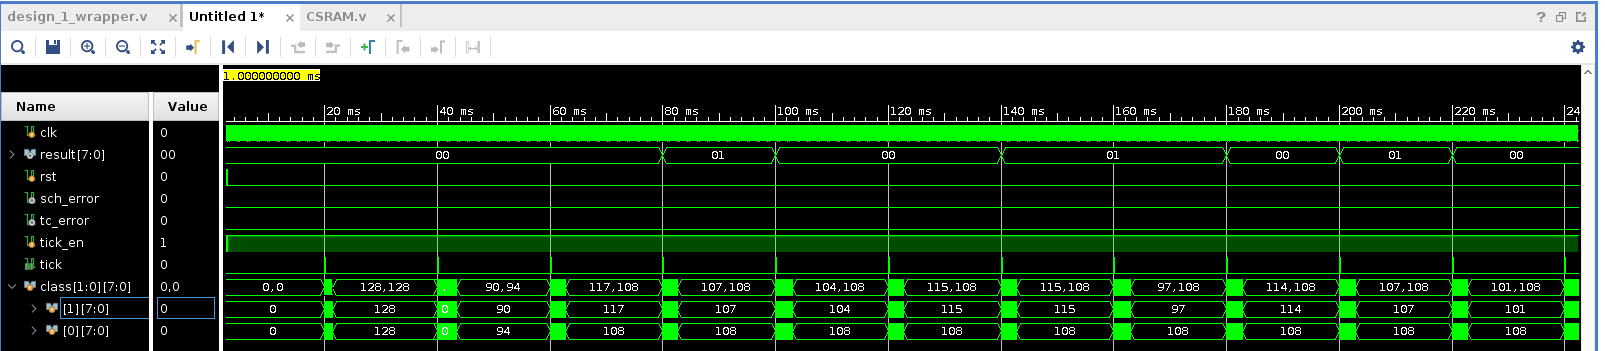 There are a couple things to notice in this waveform. 

1. `result` is the predicted class of the output.
2. The `OutcomeCore` must wait an entire tick before outputting a valid `result`. This means that at the end of a tick, `result` will become the predicted class (Means predictions happen a tick after the last core processes an image).
3. In this screenshot,  I pulled the register `class` out of the `OutcomeCore` to see the accumulated votes for each class (class\[0\] corresponds to label 0 and class\[1\] corresponds to label 1). I also pulled the `tick` signal out of `TickGenerator` to show how many time steps it takes to correctly classify an image. This makes it easy to compare to both the simulator and the training code.


This waveform shows a one-to-one correspondance betweeen the training code, the simulator, and the hardware. We are done and you can now read people's minds :-).